# Coinmap Analysis

In [191]:
# dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests as req
import json
import datetime
import scipy.stats as stats

In [192]:
# store file path
path = os.path.join('BTC-USD.csv')

# store in dataframe
btc_df = pd.read_csv(path)
btc_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-02-01,20.410000,34.520000,18.000000,33.380001,33.380001,41087388
1,2013-03-01,33.380001,95.699997,32.919998,93.029999,93.029999,123005256
2,2013-03-31,93.029999,266.000000,50.009998,139.229996,139.229996,544645777
3,2013-04-30,139.229996,140.059998,79.000000,128.820007,128.820007,233751764
4,2013-05-31,128.820007,130.100006,88.000000,97.510002,97.510002,112735944


In [193]:
# convert string to datetime object
btc_df["Date"] = pd.to_datetime(btc_df.Date)

# format date
btc_df["Date"] = btc_df["Date"].dt.strftime("%Y-%m")

# drop duplicate dates & keep last 
btc_df = btc_df.drop_duplicates(['Date'], keep='last')
    
btc_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-02,20.410000,34.520000,18.000000,33.380001,33.380001,41087388
2,2013-03,93.029999,266.000000,50.009998,139.229996,139.229996,544645777
3,2013-04,139.229996,140.059998,79.000000,128.820007,128.820007,233751764
4,2013-05,128.820007,130.100006,88.000000,97.510002,97.510002,112735944
5,2013-06,97.510002,111.650002,65.419998,106.209999,106.209999,100174821


# Coinmap API requests

In [194]:
url = "https://coinmap.org/api/v1/venues/"  
params = {'before': '2017-12-01'}

# run request and print response
response = req.get(url, params=params).json()
#print(json.dumps(response, indent = 4,sort_keys=True))

# store response in dataframe
coinmap_df = pd.DataFrame(response['venues'])

In [195]:
# create empty list
formatted_date = []

# Reformat the 'created_on' Date
for date in coinmap_df['created_on']:
    newdate = datetime.datetime.fromtimestamp(date)
    newdate2 = newdate.strftime('%Y-%m')
    formatted_date.append(newdate2) 
    
# store in new column    
coinmap_df['date(YYYY-MM)'] = formatted_date

coinmap_df.head()

,category,created_on,id,lat,lon,name,date(YYYY-MM)
0,atm,1465943680,8225,50.122064,-5.532898,One And All,2016-06
1,default,1397211665,42,60.160534,24.939049,Belle Modeste,2014-04
2,grocery,1394219130,15,48.437747,-123.312411,Slaters Meats,2014-03
3,default,1422120857,33,50.065833,14.358897,kaktusy eshop,2015-01
4,food,1370785480,3,51.549378,-0.059379,Pembury Tavern,2013-06


# Coinmap Venue Category 

In [196]:
category_counts = coinmap_df['category'].value_counts()

category_df = pd.DataFrame(category_counts)
category_df = category_df.reset_index()
category_df = category_df.rename(columns={'category':'count', 'index':'category'})
category_df

,category,count
0,default,5971
1,shopping,1648
2,food,1050
3,atm,568
4,lodging,504
5,cafe,286
6,nightlife,206
7,sports,176
8,attraction,159
9,grocery,134


In [201]:
#Use sample to shuffle
category_df = category_df.sample(frac=1)
print(category_df)

           category  count
11  trezor retailer     10
2              food   1050
4           lodging    504
0           default   5971
6         nightlife    206
13              ATM      1
8        attraction    159
10        transport    124
9           grocery    134
5              cafe    286
14    Travel Agency      1
1          shopping   1648
3               atm    568
12       drug store      1
7            sports    176


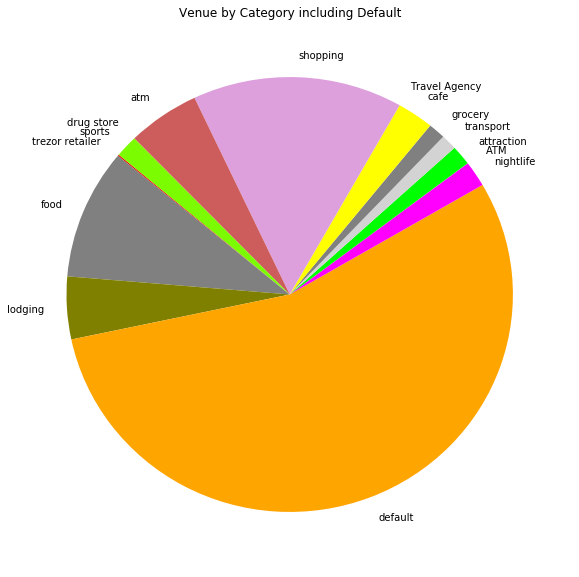

In [202]:
labels = category_df['category']
sizes = category_df['count']
colors  = ("red", "grey", "olive", "orange", "fuchsia", 
           "pink", "lime", "lightgrey", "grey", "yellow",
           "peru","plum","indianred","darkorange","lawngreen")

fig = plt.figure(figsize=[10, 10])
plt.title('Venue by Category including Default')

plt.pie(sizes, labels=labels, colors=colors, startangle=140)

plt.savefig('venue_categories.png')
plt.show()

In [203]:
#Merge Coinmap Data with Bitcoin Price Data

# group by date and create new dataframe
df_group_date = coinmap_df['date(YYYY-MM)'].value_counts()
venue_count_df = pd.DataFrame({'Venues': df_group_date})
df2 = venue_count_df.reset_index()

# rename column
venue_count_df = df2.rename(columns={'index':'Date'})

# sort date
df_summary = venue_count_df.sort_values(by=['Date'])
df_summary.head()

,Date,Venues
57,2013-02,1
56,2013-03,2
53,2013-04,35
54,2013-05,18
55,2013-06,13


In [204]:
# calculate cumulative sum
df_summary['Cumulative Sum'] = df_summary.Venues.cumsum()
df_summary = pd.merge(df_summary, btc_df, on='Date')
df_summary.head()

,Date,Venues,Cumulative Sum,Open,High,Low,Close,Adj Close,Volume
0,2013-02,1,1,20.410000,34.520000,18.000000,33.380001,33.380001,41087388
1,2013-03,2,3,93.029999,266.000000,50.009998,139.229996,139.229996,544645777
2,2013-04,35,38,139.229996,140.059998,79.000000,128.820007,128.820007,233751764
3,2013-05,18,56,128.820007,130.100006,88.000000,97.510002,97.510002,112735944
4,2013-06,13,69,97.510002,111.650002,65.419998,106.209999,106.209999,100174821


# Number of New Venues Accepting Bitcoin and Adjusted Close Price

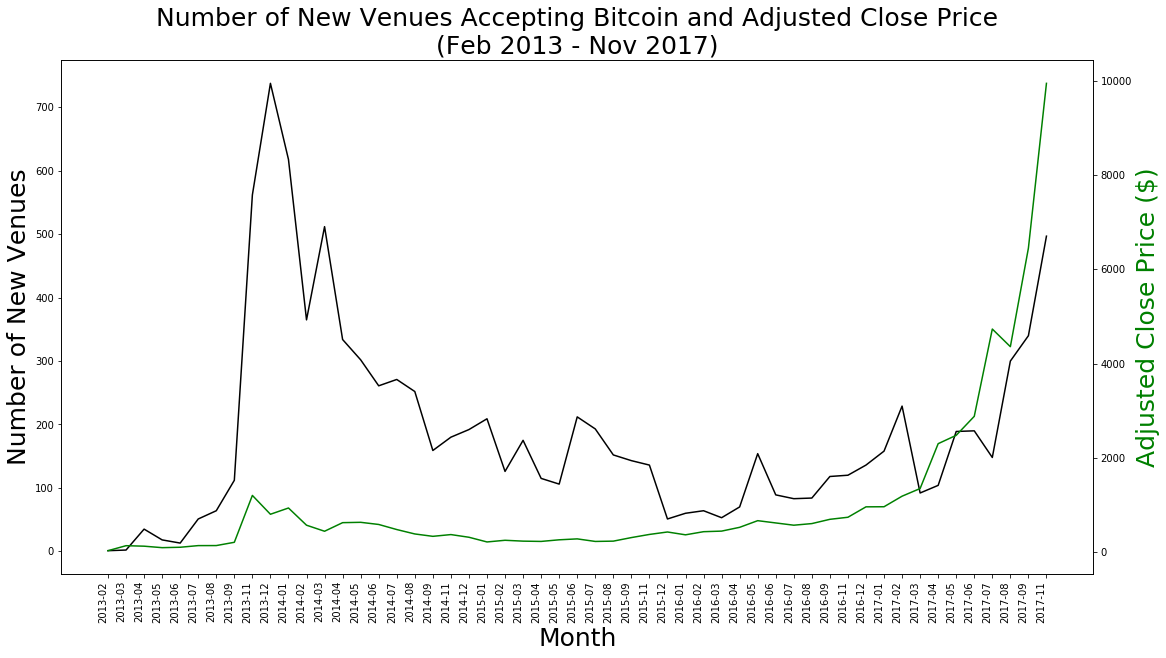

In [205]:
# plot
x = df_summary['Date']
y1 = df_summary['Venues']
y2 = df_summary['Adj Close']
fig, ax1 = plt.subplots()
fig.autofmt_xdate(rotation=90) #this needs to be before calling the twinx function
ax2 = ax1.twinx()
ax1.plot(x, y1, 'k-')
ax2.plot(x, y2, 'g-')
ax1.set_xlabel('Month', fontsize=25)
ax2.set_ylabel('Adjusted Close Price ($)', color='g', fontsize=25)
ax1.set_ylabel('Number of New Venues', color='k', fontsize=25)
plt.title('Number of New Venues Accepting Bitcoin and Adjusted Close Price\n(Feb 2013 - Nov 2017)', fontsize=25)
fig.set_size_inches(18.5, 10.5)
plt.savefig('bitcoin_new_venues_price.png')
plt.show()

In [206]:
print('Linear Regression between Number of New Venues and Adjusted Close Price per Month')
x = df_summary['Venues']
y = df_summary['Adj Close']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

r_value_newvenues_price = r_value
p_value_newvenues_price = p_value
std_err_newvenues_price = std_err

print('p_value:', p_value_newvenues_vol,'r_value:', r_value_newvenues_vol,'std_err:', std_err_newvenues_vol)

Linear Regression between Number of New Venues and Adjusted Close Price per Month
p_value: 0.0531607912403 r_value: 0.267123366076 std_err: 4574121.46135


# Number of New Venues Accepting Bitcoin and Volume

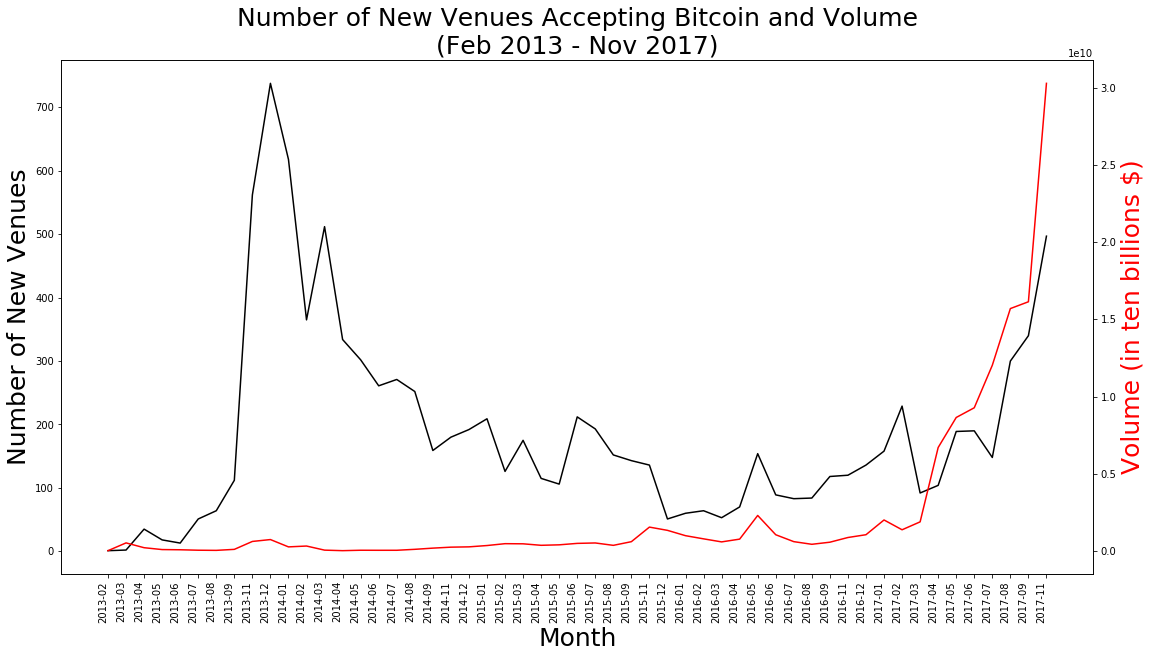

In [207]:
# plot
x = df_summary['Date']
y1 = df_summary['Venues']
y2 = df_summary['Volume']
fig, ax1 = plt.subplots()
fig.autofmt_xdate(rotation=90)
ax2 = ax1.twinx()
ax1.plot(x, y1, 'k-')
ax2.plot(x, y2, 'r-')
ax1.set_xlabel('Month', fontsize=25)
ax2.set_ylabel('Volume (in ten billions $)', color='r', fontsize=25)
ax1.set_ylabel('Number of New Venues', color='k', fontsize=25)
plt.title('Number of New Venues Accepting Bitcoin and Volume\n(Feb 2013 - Nov 2017)', fontsize=25)
plt.xticks(rotation=90)
fig.set_size_inches(18.5, 10.5)
plt.savefig('bitcoin_new_venues_volume.png')
plt.show()

In [208]:
print('Linear Regression between Number of New Venues and Volume per Month')
x = df_summary['Venues']
y = df_summary['Volume']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

r_value_newvenues_vol = r_value
p_value_newvenues_vol = p_value
std_err_newvenues_vol = std_err

print('p_value:', p_value_newvenues_vol,'r_value:', r_value_newvenues_vol,'std_err:', std_err_newvenues_vol)

Linear Regression between Number of New Venues and Volume per Month
p_value: 0.0531607912403 r_value: 0.267123366076 std_err: 4574121.46135


# Total Number of Venues Accepting Bitcoin and Volume

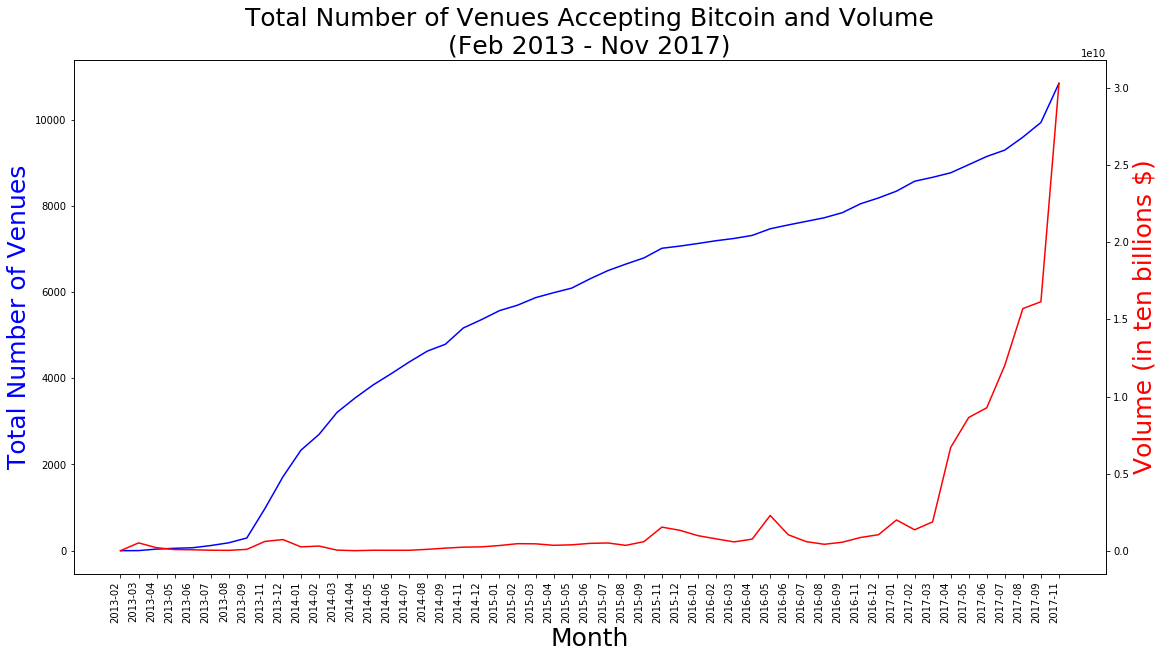

In [209]:
# plot
x = df_summary['Date']
y1 = df_summary['Cumulative Sum']
y2 = df_summary['Volume']
fig, ax1 = plt.subplots()
fig.autofmt_xdate(rotation=90)
ax2 = ax1.twinx()
ax1.plot(x, y1, 'b-')
ax2.plot(x, y2, 'r-')
ax1.set_xlabel('Month', fontsize=25)
ax2.set_ylabel('Volume (in ten billions $)', color='r', fontsize=25)
ax1.set_ylabel('Total Number of Venues', color='b', fontsize=25)
plt.title('Total Number of Venues Accepting Bitcoin and Volume\n(Feb 2013 - Nov 2017)', fontsize=25)
plt.xticks(rotation=90)
fig.set_size_inches(18.5, 10.5)
plt.savefig('bitcoin_total_venues_volume.png')
plt.show()

In [210]:
print('Linear Regression between Total Venues and Volume per Month')
x = df_summary['Cumulative Sum']
y = df_summary['Volume']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

r_value_sumvenues_vol = r_value
p_value_sumvenues_vol = p_value
std_err_sumvenues_vol = std_err

print('p_value:', p_value_sumvenues_vol,'r_value:', r_value_sumvenues_vol,'std_err:', std_err_sumvenues_vol)

Linear Regression between Total Venues and Volume per Month
p_value: 5.86665678389e-05 r_value: 0.523035212426 std_err: 206246.127474


# Total Number of Venues Accepting Bitcoin and Adjusted Close Price

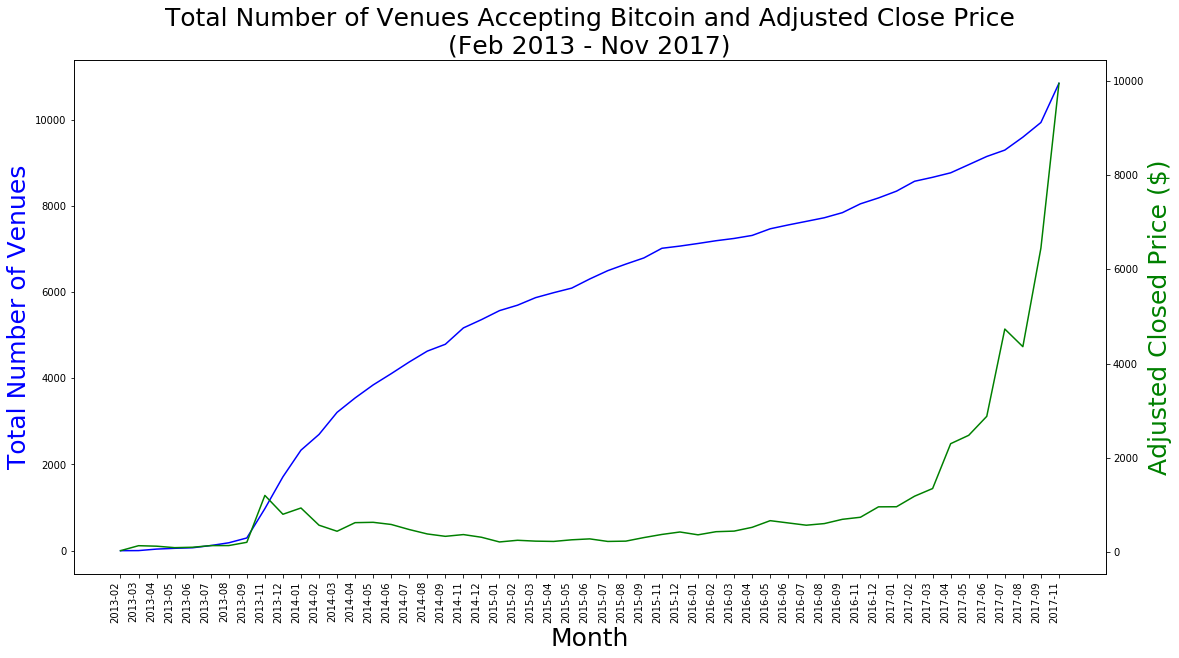

In [211]:
# plot
x = df_summary['Date']
y1 = df_summary['Cumulative Sum']
y2 = df_summary['Adj Close']
fig, ax1 = plt.subplots()
fig.autofmt_xdate(rotation=90)
ax2 = ax1.twinx()
ax1.plot(x, y1, 'b-')
ax2.plot(x, y2, 'g-')
ax1.set_xlabel('Month', fontsize=25)
ax2.set_ylabel('Adjusted Closed Price ($)', color='g', fontsize=25)
ax1.set_ylabel('Total Number of Venues', color='b', fontsize=25)
plt.title('Total Number of Venues Accepting Bitcoin and Adjusted Close Price\n(Feb 2013 - Nov 2017)', fontsize=25)
plt.xticks(rotation=90)
fig.set_size_inches(18.5, 10.5)
plt.savefig('bitcoin_total_venues_price.png')
plt.show()

In [212]:
print('Linear Regression between Number of New Venues and Adjusted Close Price per Month')
x = df_summary['Cumulative Sum']
y = df_summary['Adj Close']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

r_value_sumvenues_price = r_value
p_value_sumvenues_price = p_value
std_err_sumvenues_price = std_err

print('p_value:', p_value_sumvenues_price,'r_value:', r_value_sumvenues_price,'std_err:', std_err_sumvenues_price)

Linear Regression between Number of New Venues and Adjusted Close Price per Month
p_value: 6.88103662446e-05 r_value: 0.518856487684 std_err: 0.0673097748738


In [213]:
r_value_summary = [{'Bitcoin': 'Total Venues By Month', 
                    'Adjusted Close Price (r value)': r_value_sumvenues_price, 
                    'Adjusted Close Price (p value)': p_value_sumvenues_price , 
                    'Volume (r value)': r_value_sumvenues_vol, 
                    'Volume (p value)': p_value_sumvenues_vol},
                  {'Bitcoin': 'New Venues Per Month', 
                   'Adjusted Close Price (r value)': r_value_newvenues_price, 
                   'Adjusted Close Price (p value)': p_value_newvenues_price, 
                   'Volume (r value)': r_value_newvenues_vol, 
                   'Volume (p value)': r_value_newvenues_vol}]

df = pd.DataFrame(r_value_summary)
df= df[['Bitcoin', 'Adjusted Close Price (r value)', 
        'Adjusted Close Price (p value)', 'Volume (r value)', 
        'Volume (p value)']]
df_trans = df.transpose()
df_trans.head()

,0,1
Bitcoin,Total Venues By Month,New Venues Per Month
Adjusted Close Price (r value),0.518856,0.347564
Adjusted Close Price (p value),6.88104e-05,0.0107719
Volume (r value),0.523035,0.267123
Volume (p value),5.86666e-05,0.267123


In [214]:
#make first row column headers
df_trans = df_trans.reset_index()
header = df_trans.iloc[0] #assign the first row values as the header list
df_trans = df_trans[1:] #recreate dataframe with all rows except row 0
df2 = df_trans.rename(columns = header) #assign column names to the header list
df2.head()

,Bitcoin,Total Venues By Month,New Venues Per Month
1,Adjusted Close Price (r value),0.518856,0.347564
2,Adjusted Close Price (p value),6.88104e-05,0.0107719
3,Volume (r value),0.523035,0.267123
4,Volume (p value),5.86666e-05,0.267123
